# Distributed Q-Learning and SARSA

In [1]:
import ray
import time
import math
from copy import deepcopy
import matplotlib.pyplot as plt
from random import randint, choice, uniform
import random
%matplotlib inline
import pickle
import numpy as np
import tqdm

***

## FrozenLake  

Initialize the MDP environments.

In [2]:
import sys
from contextlib import closing

from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize, precision = 2)
#TransitionProb = [0.7, 0.1, 0.1, 0.1]
#TransitionProb = [1, 0, 0, 0]
TransitionProb = [0.97, 0.01, 0.01, 0.01]
def generate_row(length, h_prob):
    row = np.random.choice(2, length, p=[1.0 - h_prob, h_prob])
    row = ''.join(list(map(lambda z: 'F' if z == 0 else 'H', row)))
    return row


def generate_map(shape):
    """

    :param shape: Width x Height
    :return: List of text based map
    """
    h_prob = 0.1
    grid_map = []

    for h in range(shape[1]):

        if h == 0:
            row = 'SF'
            row += generate_row(shape[0] - 2, h_prob)
        elif h == 1:
            row = 'FF'
            row += generate_row(shape[0] - 2, h_prob)

        elif h == shape[1] - 1:
            row = generate_row(shape[0] - 2, h_prob)
            row += 'FG'
        elif h == shape[1] - 2:
            row = generate_row(shape[0] - 2, h_prob)
            row += 'FF'
        else:
            row = generate_row(shape[0], h_prob)

        grid_map.append(row)
        del row

    return grid_map

MAPS = {
    
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFF",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "Dangerous Hallway": [
        "SFFFFFFF",
        "FFFFFFFF",
        "HFHHHFFF",
        "HFHHHFFF",
        "HFHHHFFF",
        "HFHHHFFF",
        "HFFFFFFF",
        "FGFFFFFF"
    ],
    "16x16": [
        "SFFFFFFFFHFFFFHF",
        "FFFFFFFFFFFFFHFF",
        "FFFHFFFFHFFFFFFF",
        "FFFFFFFFHFFFFFFF",
        "FFFFFFFFFFFFFFFF",
        "FFHHFFFFFFFHFFFH",
        "FFFFFFFFFFFFFFFF",
        "FFFFFHFFFFFFHFFF",
        "FFFFFHFFFFFFFFFH",
        "FFFFFFFHFFFFFFFF",
        "FFFFFFFFFFFFHFFF",
        "FFFFFFHFFFFFFFFF",
        "FFFFFFFFHFFFFFFF",
        "FFFFFFFFFHFFFFHF",
        "FFFFFFFFFFHFFFFF",
        "FFFHFFFFFFFFFFFG",
    ],
    
    "32x32": [
        'SFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFF',
        'FFFFFFFFHFFFFFFFFFFFFFFFFFHFFFFF',
        'FFFHFFFFFFFFHFFHFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFHFHHFHFHFFFFFHFFFH',
        'FFFFHFFFFFFFFFFFFFFFHFHFFFFFFFHF',
        'FFFFFHFFFFFFFFFFHFFFFFFFFFFHFFFF',
        'FFHHFFFFHFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFHFFFFFFFFFFHFFFHFHFFFFFFFFHFF',
        'FFFFHFFFFFFHFFFFHFHFFFFFFFFFFFFH',
        'FFFFHHFHFFFFHFFFFFFFFFFFFFFFFFFF',
        'FHFFFFFFFFFFHFFFFFFFFFFFHHFFFHFH',
        'FFFHFFFHFFFFFFFFFFFFFFFFFFFFHFFF',
        'FFFHFHFFFFFFFFHFFFFFFFFFFFFHFFHF',
        'FFFFFFFFFFFFFFFFHFFFFFFFHFFFFFFF',
        'FFFFFFHFFFFFFFFHHFFFFFFFHFFFFFFF',
        'FFHFFFFFFFFFHFFFFFFFFFFHFFFFFFFF',
        'FFFHFFFFFFFFFHFFFFHFFFFFFHFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFF',
        'FFFFFFFFHFFFFFFFHFFFFFFFFFFFFFFH',
        'FFHFFFFFFFFFFFFFFFHFFFFFFFFFFFFF',
        'FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFHFFFFHFFFFFFFHFFF',
        'FFHFFFFHFFFFFFFFFHFFFFFFFFFFFHFH',
        'FFFFFFFFFFHFFFFHFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFFFHHFFHHHFFFHFFFF',
        'FFFFFFFFFFFFFFHFFFFHFFFFFFFHFFFF',
        'FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFFFHFFFFFFFFFFFFFFFFHFFHFFFFFF',
        'FFFFFFFHFFFFFFFFFHFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF',
        'FFFFFFFFFFFFFFFHFFFFFFFFHFFFFFFG',
    ]
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # BFS to check that it's a valid path.
    def is_valid(arr, r=0, c=0):
        if arr[r][c] == 'G':
            return True

        tmp = arr[r][c]
        arr[r][c] = "#"

        # Recursively check in all four directions.
        directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        for x, y in directions:
            r_new = r + x
            c_new = c + y
            if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                continue

            if arr[r_new][c_new] not in '#H':
                if is_valid(arr, r_new, c_new):
                    arr[r][c] = tmp
                    return True

        arr[r][c] = tmp
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.

    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4"):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol
        self.nS = nS
        
        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        rew_hole = -1000
        rew_goal = 1000
        rew_step = -1
        
        exit = nrow * ncol
        P = {s : {a : [] for a in range(nA)} for s in range(nS + 1)}
        
        def to_s(row, col):
            return row*ncol + col
        
        def inc(row, col, a):
            if a == LEFT:
                col = max(col-1,0)
            elif a == DOWN:
                row = min(row+1,nrow-1)
            elif a == RIGHT:
                col = min(col+1,ncol-1)
            elif a == UP:
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'H':
                        li.append((1.0, exit, -1000, True))
                    elif letter in b'G':
                        li.append((1.0, exit, 1000, True))
                    else:
                        for b, p in zip([a, (a+1)%4, (a+2)%4, (a+3)%4], TransitionProb):
                            newrow, newcol = inc(row, col, b)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            rew = rew_step
                            li.append((p, newstate, rew, False))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        if self.s < self.nS:
            desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        else:
            outfile.write("exit\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()
    

***
## Initializations

Initilize maps of different sizes and relevant parameters. 

In [3]:
#map_4 = (MAPS["4x4"], 4)
#map_8 = (MAPS["8x8"], 8)
#map_32 = (MAPS["32x32"], 32)
#map_50 = (generate_map((50,50)), 50)
#map_110 = (generate_map((110,110)), 110)

map_DH = (MAPS["Dangerous Hallway"], 8)
map_16 = (MAPS["16x16"], 16)

MAP = map_16
map_size = MAP[1]
run_time = {}

Learning_Rate = 0.001  # 0.1 , 0.001
Epsilon = 0.3 # 0.3 , 0.05
if MAP == map_DH:
    Learning_Episodes = 30000  # Dangerous Hall map
if MAP == map_16:
    Learning_Episodes = 100000  # Size 16 map

## Helper Function

In [4]:
def plot_result(total_rewards, learning_num, legend):
    print("\nLearning Performance:\n")
    episodes = []
    for i in range(len(total_rewards)):
        episodes.append(i * learning_num + 1)
        
    plt.figure(num = 1)
    fig, ax = plt.subplots()
    plt.plot(episodes, total_rewards)
    plt.title('performance')
    plt.legend(legend)
    plt.xlabel("Episodes")
    plt.ylabel("total rewards")
    plt.show()
    
def plot_image(q_table, MAP):
    
    best_value = np.max(q_table, axis = 1)[:-1].reshape((map_size,map_size))
    best_policy = np.argmax(q_table, axis = 1)[:-1].reshape((map_size,map_size))
    
    print("\n\nBest Q-value and Policy:\n")
    fig, ax = plt.subplots()
    im = ax.imshow(best_value)

    for i in range(best_value.shape[0]):
        for j in range(best_value.shape[1]):
            if MAP[i][j] in 'GH':
                arrow = MAP[i][j]
            elif best_policy[i, j] == 0:
                arrow = '<'
            elif best_policy[i, j] == 1:
                arrow = 'v'
            elif best_policy[i, j] == 2:
                arrow = '>'
            elif best_policy[i, j] == 3:
                arrow = '^'
            if MAP[i][j] in 'S':
                arrow = 'S ' + arrow
            text = ax.text(j, i, arrow,
                           ha = "center", va = "center", color = "black")
            
    cbar = ax.figure.colorbar(im, ax = ax)
    
    fig.tight_layout()
    plt.show() 
    
    

## Simulator

We now create a simulator corresponding to the environment that we want to train and test the agent in. The simulator always maintains a current state, which changes using the following functions:  
- simulator.reset(): Reset the simulator so that the current state is the initial state.   
- simulator.step(action): take the specified action in the current state, which returns the tuple (next_state, reward, done, info) and sets the internal current stae to be next_state. 

In [5]:
simulator = FrozenLakeEnv(desc = MAP[0])

***
## TDagent
The parent calss of Q-learning

In [6]:
class agent():
    def __init__(self, epsilon, learning_rate, learning_episodes, map_size, 
                 test_interval = 100, action_space = 4, beta = 0.999, do_test = True):
        self.beta = beta
        self.epsilon = epsilon
        self.test_interval = test_interval
        self.batch_num = learning_episodes // test_interval
        self.action_space = action_space
        self.state_space = map_size * map_size + 1
        self.q_table = np.zeros((self.state_space, self.action_space))
        self.learning_rate = learning_rate
        self.do_test = do_test
        
    def explore_or_exploit_policy(self, curr_state):
        if np.random.random_sample() > self.epsilon:
            return self.greedy_policy(curr_state)
        else:
            return np.random.randint(0, self.action_space)
        
    def greedy_policy(self, curr_state):
        return np.argmax(self.q_table[curr_state])
    
    def learn_and_evaluate(self):
        total_rewards = []
        for i in tqdm.tqdm(range(self.batch_num), desc="Test Number"):
            self.learn()
            if self.do_test:
                avg_reward = self.evaluate(self.greedy_policy,self.test_interval)
                total_rewards.append(avg_reward)
        return total_rewards, self.q_table
    
    def evaluate(self, policy_func, trials = 100, max_steps = 1000):
        
        total_reward = 0
        for _ in range(trials):
            simulator.reset()
            done = False
            steps = 0
            observation, reward, done, info = simulator.step(policy_func(0))
            total_reward += (self.beta ** steps) * reward
            steps += 1
            while not done and steps < 1000:
                observation, reward, done, info = simulator.step(policy_func(observation))
                total_reward += (self.beta ** steps) * reward
                steps += 1
        
        return total_reward / trials
    
    def learn(self):
        pass

***
# Distibuted Q-Learning
***
## init Ray

In [7]:
ray.shutdown()
ray.init(include_webui=False, ignore_reinit_error=True, redis_max_memory=100000000, object_store_memory=1000000000, temp_dir = '~/ray_tmp')

2021-06-21 00:21:25,936	INFO resource_spec.py:212 -- Starting Ray with 186.67 GiB memory available for workers and up to 0.93 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '10.9.1.6',
 'redis_address': '10.9.1.6:43169',
 'object_store_address': '/home/u71376/ray_tmp/session_2021-06-21_00-21-25_918054_23489/sockets/plasma_store',
 'raylet_socket_name': '/home/u71376/ray_tmp/session_2021-06-21_00-21-25_918054_23489/sockets/raylet',
 'webui_url': None,
 'session_dir': '~/ray_tmp/session_2021-06-21_00-21-25_918054_23489'}

In [8]:
@ray.remote    
class QLAgent_server(agent):
    def __init__(self, epsilon, learning_rate, learning_episodes, map_size,
                 test_interval = 100, batch_size = 100, action_space = 4, beta = 0.999, do_test = True):
        super().__init__(epsilon, learning_rate, learning_episodes, map_size, 
                         test_interval = test_interval, action_space = action_space, beta = beta, do_test = do_test)
        self.collector_done = False
        self.evaluator_done = False
        self.learning_episodes = learning_episodes
        self.episode = 0
        self.reuslts = []
        self.batch_size = batch_size
        self.privous_q_tables = []
        self.results = [0] * (self.batch_num + 1)
        self.reuslt_count = 0
        
    def learn(self, experiences):
        #INSERT YOUR CODE HERE
        
        for experience in experiences:
            for curr_state, action, reward, next_state, next_action in experience:
                self.q_table[curr_state,action] = self.q_table[curr_state,action] + self.learning_rate * (
                    reward + self.beta * self.q_table[next_state,next_action] - self.q_table[curr_state,action])
            
            self.episode += 1
        
        if self.do_test:
            if self.episode // self.test_interval + 1 > len(self.privous_q_tables):
                self.privous_q_tables.append(self.q_table)
        return self.get_q_table()
        
    def get_q_table(self):
        if self.episode >= self.learning_episodes:
            self.collector_done = True
            
        return self.q_table, self.collector_done
    
    # evalutor
    def add_result(self, result, num):
        self.results[num] = result
    
    def get_reuslts(self):
        return self.results, self.q_table
    
    def ask_evaluation(self):
        if len(self.privous_q_tables) > self.reuslt_count:
            num = self.reuslt_count
            evluation_q_table = self.privous_q_tables[num]
            self.reuslt_count += 1
            return evluation_q_table, False, num
        else:
            if self.episode >= self.learning_episodes:
                self.evaluator_done = True
            return [], self.evaluator_done, None

@ray.remote    
def collecting_worker(server, simulator, epsilon, action_space = 4, batch_size = 100, max_step = 1000):
    def greedy_policy(curr_state):
        return np.argmax(q_table[curr_state])

    def explore_or_exploit_policy(curr_state):
        if np.random.random_sample() > epsilon:
            return greedy_policy(curr_state)
        else:
            return np.random.randint(0, action_space)
        
    q_table, learn_done = ray.get(server.get_q_table.remote())
    while True:
        if learn_done:
            break
            
        collected_experiences = []  # to collect experience for server
        for i in range(batch_size):
            curr_state = simulator.reset()  # get initial state s of new episode
            experience = []  
            done = False
            while not done:
                action = explore_or_exploit_policy(curr_state)  # choose a via explore/exploit policy
                next_state, reward, done, info = simulator.step(action)  # take a and observe r and s'
                next_action = greedy_policy(next_state)
                # collect experience
                experience.append((curr_state, action, reward, next_state, next_action))
                curr_state = next_state

            collected_experiences.append(experience)
        # update Q
        server.learn.remote(collected_experiences)
        q_table, learn_done = ray.get(server.get_q_table.remote())
        
@ray.remote
def evaluation_worker(server, trials = 100, action_space = 4, beta = 0.999):
    def greedy_policy(curr_state):
        return np.argmax(q_table[curr_state])
        
    while True:
        q_table, done, num = ray.get(server.ask_evaluation.remote())
        if done:
            break
        if len(q_table) == 0:
            continue
        total_reward = 0
        for _ in range(trials):
            simulator.reset()
            done = False
            steps = 0
            observation, reward, done, info = simulator.step(greedy_policy(0))
            total_reward += (beta ** steps) * reward
            steps += 1
            while not done:
                observation, reward, done, info = simulator.step(greedy_policy(observation))
                total_reward += (beta ** steps) * reward
                steps += 1
        server.add_result.remote((total_reward / trials), num)

class distributed_QL_agent():
    def __init__(self, epsilon, learning_rate, learning_episodes, map_size, 
                 cw_num, ew_num, test_interval = 100, batch_size = 100,
                 action_space = 4, beta = 0.999, do_test = True):
        
        self.server = QLAgent_server.remote(epsilon, learning_rate, learning_episodes, map_size, 
                                               test_interval = test_interval, batch_size = batch_size, do_test = do_test)
        self.workers_id = []
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.cw_num = cw_num
        self.ew_num = ew_num
        self.agent_name = "Distributed Q-learning"
        self.do_test = do_test
        self.action_space = action_space
        self.batch_size = batch_size
        self.test_interval = test_interval
        
    def learn_and_evaluate(self):
        workers_id = []
        
        # create collector
        for _ in range(self.cw_num):
            workers_id.append(collecting_worker.remote(self.server, simulator, self.epsilon, batch_size = self.batch_size // cw_num ))
        
        # create evaluator
        if self.do_test:
            for _ in range(self.ew_num):
                workers_id.append(evaluation_worker.remote(self.server))

        ray.wait(workers_id, num_returns = len(workers_id))
        return ray.get(self.server.get_reuslts.remote())

Learning time:

72.26223826408386


Best Q-value and Policy:



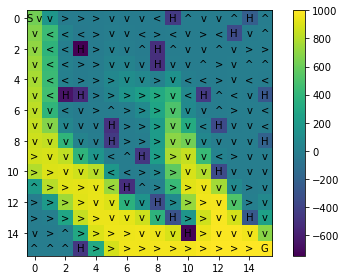

In [10]:
simulator.reset()
cw_num = 2  # 2, 4, 8
ew_num = 4
learning_rate = 0.001  # 0.1, 0.001
epsilon = 0.3
learning_episodes = Learning_Episodes
test_interval = 100
do_test = False

start_time = time.time()
distributed_ql_agent = distributed_QL_agent(epsilon, learning_rate, learning_episodes, map_size, 
                                            cw_num, ew_num, test_interval = test_interval, 
                                            batch_size = 100, do_test = do_test)
total_rewards, q_table = distributed_ql_agent.learn_and_evaluate()
run_time['Distributed Q-learning agent'] = time.time() - start_time
print("Learning time:\n")
print(run_time['Distributed Q-learning agent'])
if do_test:
    plot_result(total_rewards, test_interval, [distributed_ql_agent.agent_name])
plot_image(q_table, MAP[0])